In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#import kagglehub
#kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
#evgeniyserebryakow_cancer_res_path = kagglehub.dataset_download('evgeniyserebryakow/cancer-res')

#print('Data source import complete.')


Data source import complete.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import timeit
import re

import pandas as pd
import torch
import pickle

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 100.2 MB/s eta 0:00:00


In [4]:
!pip install pytesseract

In [5]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import io

import fitz

In [ ]:
################################ Load pdf file from Drive and
################################ Get the highest resolution images #########################

In [6]:
#doc = fitz.open(evgeniyserebryakow_cancer_res_path + "/cancer_research.pdf")
path = '/content/drive/MyDrive/Colab Notebooks/humana_chatbot/cancer_research.pdf'
doc = fitz.open(path)

zoom = 8.0
mat = fitz.Matrix(zoom, zoom)
images_lst_pix = []

for pg in range(0, doc.page_count):
    page = doc.load_page(pg)
    images_lst_pix.append([pg, page.get_pixmap(matrix=mat)])

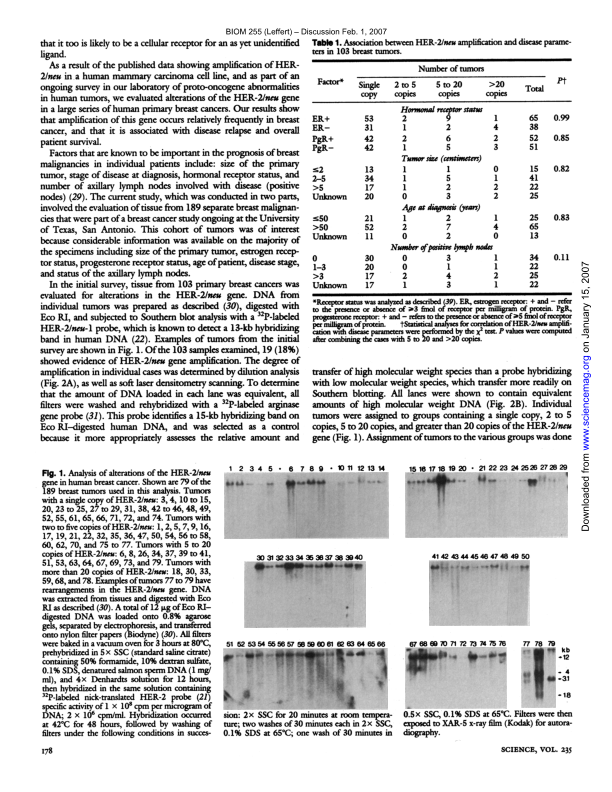

In [15]:
#### Look at specific image
#page = doc[2]
#pix = page.get_pixmap(matrix=fitz.Identity, dpi=None,
#                      colorspace=fitz.csRGB, clip=None, annots=True)

#pix.pil_image()

In [ ]:
############################## Extract text from images ###########################

In [16]:
def transfer_img_to_text(img):

    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    all_text_dt = []
    text_blocks = {}
    for i, text in enumerate(data['text']):
        if text.strip() and int(data['conf'][i]) > 0:
            block_num = data['block_num'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]

            # Group by block_num
            if block_num not in text_blocks:
                text_blocks[block_num] = {'words': [], 'coords': []}
            text_blocks[block_num]['words'].append(text)
            text_blocks[block_num]['coords'].append((x, y, w, h))

    # Process each block
    for block_id, block in text_blocks.items():
        coords = block['coords']
        x0 = min([x for x, y, w, h in coords])
        y0 = min([y for x, y, w, h in coords])
        x1 = max([x + w for x, y, w, h in coords])
        y1 = max([y + h for x, y, w, h in coords])

        cropped = img.crop((x0, y0, x1, y1))
        cropped_text = pytesseract.image_to_string(cropped, config='--psm 6')

        # Estimate average text height (proxy for font size)
        avg_height = sum([h for x, y, w, h in coords]) / len(coords)

        #print(f"\n🧱 Block {block_id}:")
        #print(f"Estimated font height: {avg_height:.1f} px")
        #print(f"Text:\n{cropped_text.strip()}")
        all_text_dt.append([block_id, avg_height, cropped_text.strip()])
    all_text_df = pd.DataFrame({'block_id': np.array(all_text_dt)[:,0],
                                'avg_height': np.array(all_text_dt)[:,1],
                                'text': np.array(all_text_dt)[:,2]})
    return all_text_df

In [17]:
all_images = pd.DataFrame()

for img in images_lst_pix:
    image = images_lst_pix[img[0]][1].pil_image()
    all_images = pd.concat([all_images, transfer_img_to_text(image)], axis=0)

In [ ]:
##################################### Handle text #########################################

In [18]:
#all_images
all_images_hndld = all_images.copy()

In [19]:
all_images_hndld['avg_height'] = all_images_hndld['avg_height'].astype(float)
all_images_hndld = all_images_hndld.reset_index()
# Font size of article size varies in range of 150 - 165
article_headers = all_images_hndld[(all_images_hndld['avg_height'] > 150) & (all_images_hndld['avg_height'] < 165)].index
#list(article_headers.index)

all_images_hndld = all_images_hndld.iloc[article_headers[0]+1:article_headers[1]]

all_images_hndld['text_len'] = [len(a) for a in all_images_hndld['text']]

# Filter out text with too many numbers, where # of numbers is exceed 30% in the text

import re

def has_more_numbers_than_words(text):
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
    words = re.findall(r'\b[a-zA-Z]+\b', text)

    return len(numbers), len(words)

all_images_hndld['num_of_numbers'] = [has_more_numbers_than_words(a)[0] for a in all_images_hndld['text']]
all_images_hndld['num_of_words'] = [has_more_numbers_than_words(a)[1] for a in all_images_hndld['text']]

all_images_hndld = all_images_hndld[all_images_hndld['num_of_numbers'] /
                   (all_images_hndld['num_of_numbers'] + all_images_hndld['num_of_words']) < 0.30]

In [20]:
def filter_values_with_numbers_in_front(txt):
    txt = str(txt).split('\n\n')
    check_lst = []
    for a in txt:
        check_lst.append(bool(re.match(r'^\s*\d+\.', a)))

    if len(set(check_lst)) == 1 and str(set(check_lst)) == '{True}':
        return '1'
    else: return '0'

In [21]:
all_images_hndld['filter_numbers_in_front'] = [filter_values_with_numbers_in_front(a)
                                               for a in all_images_hndld['text']]

all_images_hndld = all_images_hndld[all_images_hndld['filter_numbers_in_front'] == '0']

In [22]:
# Filter out text with data and tables
all_images_hndld['tables_flag'] = ['1' if bool(re.search(r'^\bTable\s+\d+\.', a)) else '0'
                                   for a in all_images_hndld['text']]

all_images_hndld = all_images_hndld[all_images_hndld['tables_flag'] == '0']

In [19]:
all_images_hndld

,index,block_id,avg_height,text,text_len,num_of_numbers,num_of_words,filter_numbers_in_front,tables_flag
19,2,3,92.941176,"DENNIs J. SLAMON,* GARY M. CLARK, STEVEN G. WO...",98,0,17,0,0
20,3,4,66.906832,The HER-2/neu oncogene is a member of the erbB...,1034,8,164,0,0
21,4,5,58.037736,HE EVIDENCE LINKING PROTO-ONCOGENES TO THE IND...,366,1,53,0,0
22,5,6,60.500000,oncogenes and the viral oncogenes of transform...,62,0,8,0,0
23,6,7,61.038710,are known to be tumorigenic in some species (1...,1035,16,143,0,0
25,8,9,60.677165,transforming gene of the simian sarcoma virus ...,2351,42,373,0,0
26,9,10,48.625000,"D. J. Slamon, S. G. Wong, and W. J. Levin are ...",76,0,16,0,0
27,10,11,47.737705,Ora wih Department of Medicine and Jonsson Ont...,383,3,61,0,0
28,11,12,50.500000,*To whom correspondence should be addressed.,44,0,6,0,0
30,13,14,282.000000,™\noO\noO\nAl\nS\n—\n>\n;\nO\n_)\nCc\n©\n&\nCc...,100,0,23,0,0


In [23]:
# Filter out more text data
all_images_hndld['avg_height'] = all_images_hndld['avg_height'].astype(float)
all_images_hndld = all_images_hndld.drop(columns='index', axis=1)
flag = []
for a in range(0, all_images_hndld.shape[0]):
    try:
        prev_value = all_images_hndld.iloc[a-1,1]
    except: prev_value = 0
    try:
        next_value = all_images_hndld.iloc[a+1,1]
    except: next_value = 0

    if all_images_hndld.iloc[a,1] > 62 and all_images_hndld.iloc[a,3] < 300 and \
       prev_value >= 58 and prev_value <= 62 and \
       next_value >= 58 and next_value <= 62:
            flag.append('0')
    elif all_images_hndld.iloc[a,1] > 62 and all_images_hndld.iloc[a,3] < 300 and \
       prev_value >= 58 and prev_value <= 62 and \
       next_value == 0:
            flag.append('0')
    elif all_images_hndld.iloc[a,1] > 62 and all_images_hndld.iloc[a,3] < 300 and \
       next_value >= 58 and next_value <= 62 and \
       prev_value == 0:
            flag.append('0')
    elif all_images_hndld.iloc[a,1] > 62 and all_images_hndld.iloc[a,3] < 300: flag.append('1')
    else: flag.append('0')

all_images_hndld['remove_txt_flag'] = flag
all_images_hndld = all_images_hndld[all_images_hndld['remove_txt_flag'] == '0']

In [24]:
all_images_hndld = all_images_hndld[(all_images_hndld['avg_height'] >= 58) & (all_images_hndld['avg_height'] <= 66)]

In [25]:
full_text = ''.join(all_images_hndld['text'].astype(str))

In [26]:
paragraphs = re.split(r'\n\n|\|', full_text)

In [27]:
def merge_short_chunks(chunks, min_length=100):
    merged = []
    i = 0
    while i < len(chunks):
        current = chunks[i].strip()
        if len(current) < min_length:
            if i + 1 < len(chunks):
                current += ' ' + chunks[i + 1].strip()
                i += 1
        merged.append(current)
        i += 1
    return merged

In [28]:
joint_paragraphs = merge_short_chunks(paragraphs)

In [29]:
joint_paragraphs_hndld = []

for par in joint_paragraphs:
    lines = par.split('\n')
    joined_text = ' '.join(line.strip() for line in lines if line.strip()).lower()
    joint_paragraphs_hndld.append(joined_text)

In [ ]:
########################### Clean and handle text. NLP ###########################

In [30]:
def apply_regex_proc(txt):

    pattern_1 = r'\(\s*(?:\d+\s*[-–]\s*\d+|\d+\s*,\s*\d+|\d+|([a-zA-Z])\1*)\s*\)'
    pattern_2 = r'\( *(fig\.|table) .*?\)'
    pattern_3 = r'\(\d+(?:,\s*\d+)*\)'
    pattern_4 = r'\(iit\)|\(1i\)|\||,|/'

    new_string = re.sub(pattern_1, '', txt, flags=re.IGNORECASE)
    new_string = re.sub(pattern_2, '', new_string)
    new_string = re.sub(pattern_3, '', new_string)
    new_string = re.sub(pattern_4, '', new_string)

    new_string = re.sub(r'[()]', '', new_string)
    new_string = re.sub(r'- ', '-', new_string)
    new_string = re.sub(r'\s+([.;:])', r'\1', new_string)
    new_string = re.sub(r'\s{2,}', ' ', new_string)

    return new_string

In [31]:
joint_paragraphs_hndld_reg = []

for a in joint_paragraphs_hndld:
    joint_paragraphs_hndld_reg.append(apply_regex_proc(a))

In [ ]:
######################################### Retrieve text summary ##############################

In [32]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.0 MB/s eta 0:00:00


In [33]:
#from transformers import AutoTokenizer, AutoModelForCausalLM

#tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large")
#model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/566k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [ ]:
#from transformers import pipeline

#summarizer = pipeline("summarization", model="facebook/bart-large-cnn", framework="pt", device=-1)

#all_summ_chunks = []
#for chunk in joint_paragraphs_hndld_reg:
#    chunk_summary = summarizer(chunk, max_length=58, min_length=30, do_sample=False)
#    all_summ_chunks.append(chunk_summary[0]['summary_text'])

Device set to use cpu


In [36]:
from transformers import pipeline
#summarizer = pipeline("summarization", model="allenai/led-base-16384", device=-1)
summarizer = pipeline("summarization", model="google/pegasus-large", device=-1)

txt = "".join(joint_paragraphs_hndld_reg)

#allenai_summ_all = summarizer(txt, max_length=700, min_length=600, do_sample=False)
#allenai_summ_all = summarizer(txt, top_k=50, top_p=0.95,max_length=700, min_length=600, do_sample=True, repetition_penalty=1.2)

goog_summ_chunks = []
for chunk in joint_paragraphs_hndld_reg:
    chunk_summary = summarizer(chunk, max_length=65, min_length=30, do_sample=False)
    goog_summ_chunks.append(chunk_summary[0]['summary_text'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [ ]:
txt = "".join(all_summ_chunks)
#summarizer = pipeline("summarization", model="facebook/bart-large-cnn", framework="pt", device=-1)

all_summary = summarizer(txt, max_length=600, min_length=20, do_sample=False)

In [ ]:
#txt = "".join(joint_paragraphs_hndld_reg)

#print(len(tokenizer(txt, add_special_tokens=False)["input_ids"]))

3538


In [ ]:
#txt = "".join(all_summ_chunks)

#print(len(tokenizer(txt, add_special_tokens=False)["input_ids"]))

793


In [37]:
txt = "".join(goog_summ_chunks)

print(len(tokenizer(txt, add_special_tokens=False)["input_ids"]))

805


In [ ]:
#full text in 17 chunks: joint_paragraphs_hndld_reg
#summary of the text in 17 chunks: goog_summ_chunks

#tokenization mechanizm:
#from transformers import AutoTokenizer, AutoModelForCausalLM
#tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large")
#tokenizer(txt, add_special_tokens=False)["input_ids"]

In [ ]:
#pip install transformers torch spacy
#python -m spacy download en_core_web_sm

In [38]:
#!pip install scispacy --no-deps
#!pip install scispacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 115.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: blis
    Found existing installation: blis 1.3.0
    Uninstalling blis-1.3.0:
      Successfully uninstalled bli

In [39]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 64.0 MB/s eta 0:00:00
  Created wheel for en_ner_bionlp13cg_md: filename=en_ner_bionlp13cg_md-0.5.1-py3-none-any.whl size=120241137 sha256=83adf17edadc2b5375990d9744cc28bbcb128e5f73ab9fe1994f3566b4040b57
  Stored in directory: /root/.cache/pip/wheels/1b/48/06/cb86feaf8cf8bb0d00a9465e788e3f19cc81e931c6a69b9859
Successfully built en_ner_bionlp13cg_md
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.

In [ ]:
#!pip install nmslib
#!pip install https://files.pythonhosted.org/packages/47/c8/e1bb26c70bd692d1d27fdfb08c0e06fea815d4a75027605479c612576b30/nmslib-2.1.1.tar.gz
#!pip install faiss-cpu
#!pip install nmslib-metabrainz==2.1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 984.6 kB/s eta 0:00:0000:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.5 requires conllu, which is not installed.
scispacy 0.5.5 requires pysbd, which is not installed.
scispacy 0.5.5 requires nmslib-metabrainz==2.1.3; python_version >= "3.11", but you have nmslib-metabrainz 2.1.2 which is incompatible.


In [ ]:
#!pip install pysbd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.5 requires conllu, which is not installed.
scispacy 0.5.5 requires nmslib-metabrainz==2.1.3; python_version >= "3.11", but you have nmslib-metabrainz 2.1.2 which is incompatible.


In [ ]:
###################################################### Generate Pairs (Question - Answer) ##############################

In [40]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

  Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (920 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling thinc-8.1.12:
      Successfully uninstalled thinc-8.1.12
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-bionlp13cg-md 0.5.1 requires spacy<3.5.0,>=3.4.1, but you have spacy 3.7.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
!pip install -U numpy==1.23.5
!pip install -U spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 106.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-bionlp13cg-md 0.5.1 requires spacy<3.5.0,>=3.4.1, but you have spacy 3.7.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 130.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.22
    Uninstalling pydantic-1.10.22:
      Successfully uninstalled pydantic-1.10.22
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uni

In [42]:
import spacy
import scispacy

from scispacy.linking import EntityLinker
nlp = spacy.load("en_core_sci_sm")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [2]:
#linker = scispacy.umls_linking.UmlsEntityLinker(resolve_abbreviations=True)
#nlp.add_pipe("scispacy_linker", last=True, config={"resolve_abbreviations": True, "linker_name": "umls"})

#nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpkr2zef7m


100%|██████████| 492M/492M [00:23<00:00, 22.4MiB/s]


Finished download, copying /tmp/tmpkr2zef7m to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmphy2kuxbu


100%|██████████| 724M/724M [00:17<00:00, 43.2MiB/s]


Finished download, copying /tmp/tmphy2kuxbu to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpreozepkb


100%|██████████| 1.32M/1.32M [00:00<00:00, 5.51MiB/s]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Finished download, copying /tmp/tmpreozepkb to cache at /root/.scispacy/datasets/37bc06bb7ce30de7251db5f5cbac788998e33b3984410caed2d0083187e01d38.f0994c1b61cc70d0eb96dea4947dddcb37460fb5ae60975013711228c8fe3fba.tfidf_vectorizer.joblib
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmp7vw4lzrr


100%|██████████| 264M/264M [00:06<00:00, 43.3MiB/s]


Finished download, copying /tmp/tmp7vw4lzrr to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmpalyl74aq


100%|██████████| 628M/628M [00:16<00:00, 39.6MiB/s]


Finished download, copying /tmp/tmpalyl74aq to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp6l90vrqv


100%|██████████| 4.26k/4.26k [00:00<00:00, 7.18MiB/s]

Finished download, copying /tmp/tmp6l90vrqv to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f8966c4178b892190a302b21836f.330707f4efe774134872b9f77f0e3208c1d30f50800b3b39a6b8ec21d9adf1b7.umls_semantic_type_tree.tsv


In [43]:
import scispacy
import spacy
#import en_core_sci_sm
#import scispacy.umls_linking
from scispacy.linking import EntityLinker
from collections import defaultdict

# Load SciSpacy with UMLS linker
#nlp = en_core_sci_sm.load()
#linker = scispacy.umls_linking.UmlsEntityLinker(resolve_abbreviations=True)
#nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

linker = EntityLinker(resolve_abbreviations=True, name="umls")
nlp.add_pipe("scispacy_linker", last=True, config={"resolve_abbreviations": True, "linker_name": "umls"})
#nlp.add_pipe(linker, last=True)

text = "".join(joint_paragraphs_hndld_reg)

doc = nlp(text)

# UMLS semantic type to custom category map
semtype_to_category = {
    "T028": "genes",             # Gene or Genome
    "T191": "diseases",          # Neoplastic Process
    "T046": "concepts",          # Pathologic Function
    "T033": "processes",         # Finding (e.g. signal transduction)
    "T059": "metrics",           # Laboratory Procedure / Quantitative concept
    "T201": "subjects",          # Clinical Attribute (status, node, etc.)
}

# Extract and classify
buckets = defaultdict(set)

for ent in doc.ents:
    for umls_ent in ent._.kb_ents:
        cui = umls_ent[0]
        score = umls_ent[1]
        concept = linker.kb.cui_to_entity[cui]
        #concept = EntityLinker.umls.cui_to_entity[cui]
        for semtype in concept.types:
            semtype_id = semtype.split(":")[-1]
            category = semtype_to_category.get(semtype_id)
            if category:
                buckets[category].add(ent.text)
                break

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmp169gw2tf


100%|██████████| 492M/492M [00:55<00:00, 9.24MiB/s]


Finished download, copying /tmp/tmp169gw2tf to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmps1epvctw


100%|██████████| 724M/724M [00:50<00:00, 14.9MiB/s]


Finished download, copying /tmp/tmps1epvctw to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpqw02sxcy


100%|██████████| 1.32M/1.32M [00:01<00:00, 1.32MiB/s]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Finished download, copying /tmp/tmpqw02sxcy to cache at /root/.scispacy/datasets/37bc06bb7ce30de7251db5f5cbac788998e33b3984410caed2d0083187e01d38.f0994c1b61cc70d0eb96dea4947dddcb37460fb5ae60975013711228c8fe3fba.tfidf_vectorizer.joblib
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpy06efi92


100%|██████████| 264M/264M [00:17<00:00, 15.7MiB/s]


Finished download, copying /tmp/tmpy06efi92 to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmpst3we99g


100%|██████████| 628M/628M [00:49<00:00, 13.2MiB/s]


Finished download, copying /tmp/tmpst3we99g to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmpn998f5v5


100%|██████████| 4.26k/4.26k [00:00<00:00, 9.01MiB/s]


Finished download, copying /tmp/tmpn998f5v5 to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f8966c4178b892190a302b21836f.330707f4efe774134872b9f77f0e3208c1d30f50800b3b39a6b8ec21d9adf1b7.umls_semantic_type_tree.tsv


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large")

tokenizer(txt, add_special_tokens=False)["input_ids"]

In [92]:
import numpy as np
from numpy.linalg import norm

In [170]:
import random
import torch
import re
from hashlib import md5
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import numpy as np
from numpy.linalg import norm
from multiprocessing import Pool, cpu_count

# Load the scispaCy model
#nlp = spacy.load("en_core_sci_md")

model_name = "microsoft/biogpt-large"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)
#model.eval()

In [177]:
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

def precompute_chunk_embeddings(chunks):
    return [(chunk, embed_text(chunk)) for chunk in chunks]

def get_most_relevant_sentence_fast(question, chunk_embeddings, threshold=0.7):
    q_embedding = embed_text(question)

    max_sim = 0.0
    best_chunk = "Question is irrelevant."

    for chunk, emb in chunk_embeddings:
        sim = cosine_similarity([q_embedding], [emb])[0][0]
        if sim > max_sim:
            max_sim = sim
            best_chunk = chunk

    return best_chunk if max_sim > threshold else "Question is irrelevant."

def generate_qa_pairs_batch(doc_chunks, over_txt_chunks, num_pairs):
    all_chunks = doc_chunks + over_txt_chunks
    chunk_embeddings = precompute_chunk_embeddings(all_chunks)

    templates = [
        ("What evidence links {subject} to {concept}?", "evidence"),
        ("Which gene is associated with {concept}?", "gene"),
        ("How is {gene} related to {concept}?", "relation"),
        ("What are the implications of {gene} amplification?", "implications"),
        ("Where is the {gene} gene located?", "location"),
        ("What are the known prognostic factors for {disease}?", "factors"),
        ("How does {gene} amplification correlate with {metric}?", "correlation"),
        ("What role does {gene} play in {process}?", "role"),
    ]

    subjects = list(buckets['subjects'])
    concepts = list(buckets['concepts'])
    metrics = list(buckets['metrics'])
    genes = list(buckets['genes'])
    processes = list(buckets['processes'])
    diseases = list(buckets['diseases'])

    new_qa = []
    used_questions = set()

    while len(new_qa) < num_pairs:
        q_template, _ = random.choice(templates)
        q = q_template.format(
            subject=random.choice(subjects),
            concept=random.choice(concepts),
            gene=random.choice(genes),
            process=random.choice(processes),
            disease=random.choice(diseases),
            metric=random.choice(metrics)
        )
        q_hash = md5(q.encode()).hexdigest()
        if q_hash not in used_questions:
            a = get_most_relevant_sentence_fast(q, chunk_embeddings)
            if a != "Question is irrelevant.":
                new_qa.append((q, a))
            used_questions.add(q_hash)

    return new_qa

In [186]:
tic = timeit.default_timer()

chunks = joint_paragraphs_hndld_reg[0]
over_txt = "".join(goog_summ_chunks[0])

all_chunks = chunks # + over_txt
chunk_embeddings = precompute_chunk_embeddings(all_chunks)

toc = timeit.default_timer()
print(f"Time elapsed: {toc - tic:.2f} seconds")

KeyboardInterrupt: 

In [224]:
#chunk_tens = tokenizer(all_chunks, return_tensors="pt", truncation=True, max_length=512)['input_ids']
#question_tens = tokenizer('What are the implications of tumor progression amplification?', return_tensors="pt", truncation=True, max_length=512)['input_ids']

#a_tokens = set(chunk_tens[0].tolist())
#b_tokens = set(question_tens[0].tolist())

#overlap = a_tokens.intersection(b_tokens)
#overlap_ratio = len(overlap) / len(b_tokens)  # % of b tokens found in a
#print("Overlap tokens:", overlap)
#print("Overlap ratio:", overlap_ratio)

Overlap tokens: {2, 2018, 8, 9, 48, 157}
Overlap ratio: 0.6
